p0 = [np.int64(20), np.float64(5979.942100909842), np.int64(100), np.int64(0), np.float64(105.08684863523573), np.int64(100), 0.001, 0.002]
bounds = ([0, 5000, 100, 0, 10, 100, 0, 1e-05], [inf, 7000, 500, inf, 5400.0, 1000, inf, 0.1])
🎯 전체 이벤트 수 (from histogram): 376
📊 Histogram 기반 이벤트 수 (±2σ 범위)
✅ On-shell 범위: [5494.1, 6494.1] GeV
▶ On-shell 이벤트 수: 353
✅ Off-shell 범위: [0.0, 423.7] GeV
▶ Off-shell 이벤트 수: 0


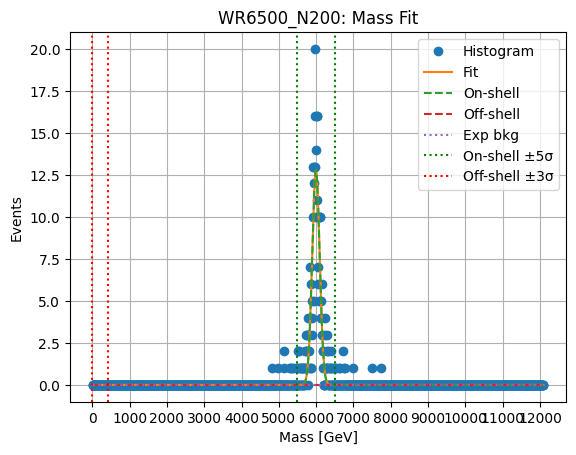

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson

# CSV 로드
df = pd.read_csv("./histogram/data/WR6000_mass_histograms.csv")

# 사용할 히스토그램 선택
mass_bins = df["mass_bin_center"]
counts = df["result_WR6000_N4300"].fillna(0).values

# WR mass 기준 (여기선 1000)
WR_mass =6000

# 모델 정의
def double_gauss_exp(x, A1, mu1, sigma1, A2, mu2, sigma2, a, b):
    return (
        A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) +
        A2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) +
        a  * np.exp(-b * x)
    )

def single_gauss_exp(x, A1, mu1, sigma1, a, b):
    return (
        A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) +
        a  * np.exp(-b * x)
    )

# Crystal Ball + exponential background
def cb_exp(x, alpha, n, sigma, a, b):
    mean = WR_mass  # WR mass 고정
    N = 1.0  # scale factor를 A로 따로 넣을 수도 있음
    cb = crystal_ball(x, alpha, n, mean, sigma, N)
    return cb + a * np.exp(-b * x)


# --- mu1_guess 조정 ---
peak_idx = np.argmax(counts)
mu1_guess = np.clip(mass_bins[peak_idx], WR_mass - 500, WR_mass + 500)
mu1_guess = np.clip(mu1_guess, WR_mass - 500, WR_mass + 500)
A1_guess = counts[peak_idx]
sigma1_guess= 50
sigma1_guess = np.clip(sigma1_guess, 100, 200)
a_guess = counts[-1] / 2
if a_guess == 0:
    a_guess = max(counts[-1] / 2, 1e-3)
b_guess = 0.002
# --- mu2_guess 조정 (offshell용) ---

left_mask = (mass_bins < WR_mass * 0.7) & (mass_bins > 100)
mu2_guess = 0
A2_guess = 0
sigma2_guess = 100
# off-shell 초기값 추정
left_mask = (mass_bins < WR_mass * 0.7) & (mass_bins > 100)
if left_mask.sum() > 0:
    A2_guess = counts[left_mask].max()
    mu2_guess = mass_bins[left_mask].iloc[np.argmax(counts[left_mask])]
    mu2_guess = np.clip(mu2_guess, 10, WR_mass * 0.9 - 10)
    sigma2_guess = np.clip(sigma2_guess, 100, 500)
    fit_type = "double"

    # mu2_guess가 WR_mass * 0.7보다 커지지 않게 제한
    if mu2_guess > WR_mass * 0.8:
        mu2_guess = WR_mass * 0.5

else:
    fit_type = "single"

# 피팅
try:
    if fit_type == "double":
        p0 = [A1_guess, mu1_guess, sigma1_guess, A2_guess, mu2_guess, sigma2_guess, a_guess, b_guess]
        bounds = (
            [0, WR_mass - 1000, 100,   0, 10, 100, 0, 0.00001],  # 최소값
            [np.inf, WR_mass + 1000, 500, np.inf, WR_mass * 0.9, 1000, np.inf, 0.1]  # 최대값
        )
        print("p0 =", p0)
        print("bounds =", bounds)
        popt, _ = curve_fit(double_gauss_exp, mass_bins, counts, p0=p0, bounds=bounds, maxfev=200000)
        A1, mu1, sigma1, A2, mu2, sigma2, a, b = popt

    else:
        p0 = [A1_guess, mu1_guess, sigma1_guess, a_guess, b_guess]
        bounds = (
            [0, WR_mass - 500, 10, 0, 0.00001],
            [np.inf, WR_mass + 500, 200, np.inf, 0.1]
        )
        print("p0 =", p0)
        print("bounds =", bounds)
        popt, _ = curve_fit(single_gauss_exp, mass_bins, counts, p0=p0, bounds=bounds, maxfev=200000)
        A1, mu1, sigma1, a, b = popt


    # 시각화용 x 범위
    x_fit = np.linspace(min(mass_bins), max(mass_bins), 1000)

    # 계산
    gauss1 = A1 * np.exp(-0.5 * ((x_fit - mu1) / sigma1) ** 2)
    expo   = a  * np.exp(-b * x_fit)
    on_shell_events = simpson(gauss1, x_fit)
    off_shell_events = 0
    total_fit = gauss1 + expo

    if fit_type == "double":
        gauss2 = A2 * np.exp(-0.5 * ((x_fit - mu2) / sigma2) ** 2)
        off_shell_events = simpson(gauss2, x_fit)
        total_fit += gauss2

        # 결과 출력
        total_events = counts.sum()  # 원래 데이터 전체 합계
        print(f"🎯 전체 이벤트 수 (from histogram): {total_events}")
        
        
        on_N_sigma = 5  # 4시그마 범위 사용
        off_N_sigma = 3  # 4시그마 범위 사용

        # 실제 histogram 데이터 기준으로 범위 선택
        if fit_type == "double":
            on_min = mu1 - on_N_sigma * sigma1
            on_max = mu1 + on_N_sigma * sigma1
            on_mask = (mass_bins >= on_min) & (mass_bins <= on_max)
            on_count = counts[on_mask].sum()

            off_min = mu2 - off_N_sigma * sigma2
            if off_min <0 :
                off_min = 0
            off_max = mu2 + off_N_sigma * sigma2

            # 마스크 생성
            on_mask = (mass_bins >= on_min) & (mass_bins <= on_max)
            off_mask = (mass_bins >= off_min) & (mass_bins <= off_max)
            off_mask = (mass_bins >= off_min) & (mass_bins <= off_max)
            off_count = counts[off_mask].sum()
            

            print("📊 Histogram 기반 이벤트 수 (±2σ 범위)")
            print(f"✅ On-shell 범위: [{on_min:.1f}, {on_max:.1f}] GeV")
            print(f"▶ On-shell 이벤트 수: {on_count}")
            print(f"✅ Off-shell 범위: [{off_min:.1f}, {off_max:.1f}] GeV")
            print(f"▶ Off-shell 이벤트 수: {off_count}")

        else:
            on_min = mu1 - on_N_sigma * sigma1
            on_max = mu1 + on_N_sigma * sigma1
            on_mask = (mass_bins >= on_min) & (mass_bins <= on_max)
            on_count = counts[on_mask].sum()

        
            print("📊 Histogram 기반 이벤트 수 (±2σ 범위)")
            print(f"✅ On-shell 범위: [{on_min:.1f}, {on_max:.1f}] GeV")
            print(f"▶ On-shell 이벤트 수: {on_count}")
            print(f"❕ Off-shell 피팅 없음")


    # 그림
    plt.plot(mass_bins, counts, 'o', label="Histogram")
    plt.plot(x_fit, total_fit, '-', label="Fit")
    plt.plot(x_fit, gauss1, '--', label="On-shell")
    if fit_type == "double":
        plt.plot(x_fit, gauss2, '--', label="Off-shell")
    plt.plot(x_fit, expo, ':', label="Exp bkg")
    plt.title("WR6500_N200: Mass Fit")
    plt.xlabel("Mass [GeV]")
    xtick_range = np.arange(0, max(mass_bins)+1, 1000)
    plt.xticks(xtick_range)
    plt.axvline(on_min, color='green', linestyle=':', label='On-shell ±5σ')
    plt.axvline(on_max, color='green', linestyle=':')
    if fit_type == "double":
        plt.axvline(off_min, color='red', linestyle=':', label='Off-shell ±3σ')
        plt.axvline(off_max, color='red', linestyle=':')
    plt.ylabel("Events")
    plt.grid(True)
    plt.legend()
    plt.show()

except RuntimeError as e:
    print(f"❌ 피팅 실패: {e}")

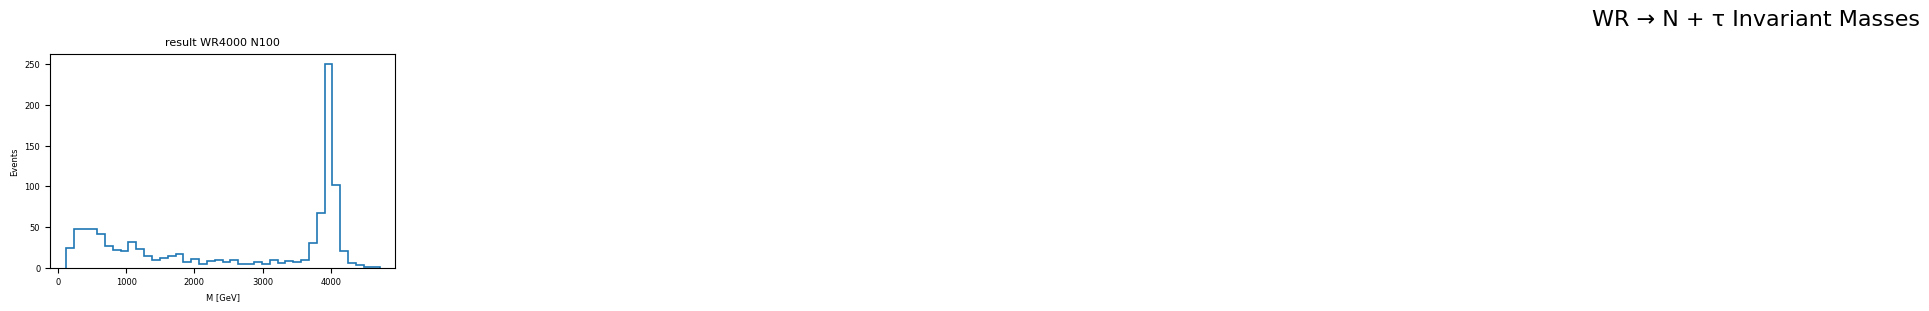

In [13]:
import pyhepmc as hep
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

class WRMassReconstructor:
    def __init__(self):
        self.masses = []

    def SetInput(self, input_file):
        self.input = hep.open(input_file)

    def SetTargetParticles(self, id1, id2):
        self.id1 = id1
        self.id2 = id2

    def Run(self):
        for event in self.input:
            p1 = None
            p2 = None
            for p in event.particles:
                if p1 is None and p.pid == self.id1:
                    p1 = p
                elif p2 is None and p.pid == self.id2:
                    p2 = p
            if p1 and p2:
                vec1 = self._get_four_vector(p1.momentum)
                vec2 = self._get_four_vector(p2.momentum)
                mass = self._invariant_mass(vec1, vec2)
                self.masses.append(mass)
        self.input.close()

    @staticmethod
    def _get_four_vector(momentum):
        px, py, pz, E = momentum
        return {"E": E, "px": px, "py": py, "pz": pz}

    @staticmethod
    def _invariant_mass(p1, p2):
        E = p1["E"] + p2["E"]
        px = p1["px"] + p2["px"]
        py = p1["py"] + p2["py"]
        pz = p1["pz"] + p2["pz"]
        return np.sqrt(max(E**2 - px**2 - py**2 - pz**2, 0))


# === 실행 파트 ===
base_path = "/data6/Users/snuintern1/fork_gen_999/submit_files/condorfiles/LO999"
lhe_files = sorted(glob.glob(f"{base_path}/result_WR4000_N100/cmsgrid_final.lhe"))

n_files = len(lhe_files)
cols = 10
rows = (n_files + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3 * rows), constrained_layout=True)
axes = axes.flatten()

for idx, lhe_path in enumerate(lhe_files):
    label = os.path.basename(os.path.dirname(lhe_path))
    try:
        reco = WRMassReconstructor()
        reco.SetInput(lhe_path)
        reco.SetTargetParticles(9900016, 15)
        reco.Run()

        ax = axes[idx]
        ax.hist(reco.masses, bins=40, histtype='step', linewidth=1.2)
        ax.set_title(label.replace("_", " "), fontsize=8)
        ax.set_xlabel("M [GeV]", fontsize=6)
        ax.set_ylabel("Events", fontsize=6)
        ax.tick_params(axis='both', which='major', labelsize=6)

    except Exception as e:
        print(f"❌ Error processing {label}: {e}")
        axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')

# 남은 subplot은 지우기
for i in range(len(lhe_files), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("WR → N + τ Invariant Masses", fontsize=16)
#plt.savefig("all_WR_mass_plots.png", dpi=200)
plt.show()

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Crystal Ball 함수 ---
def crystal_ball(x, alpha, n, mean, sigma):
    t = (x - mean) / sigma
    abs_alpha = np.abs(alpha)
    A = (n / abs_alpha)**n * np.exp(-0.5 * abs_alpha**2)
    B = n / abs_alpha - abs_alpha
    result = np.where(
        t > -abs_alpha,
        np.exp(-0.5 * t**2),
        A * (B - t)**(-n)
    )
    return result

# --- Double Crystal Ball 모델 ---
def double_crystal_ball(x, N1, alpha1, n1, sigma1, N2, alpha2, n2, mu2, sigma2):
    mean1 = WR_mass
    cb1 = N1 * crystal_ball(x, alpha1, n1, mean1, sigma1)
    cb2 = N2 * crystal_ball(x, alpha2, n2, mu2, sigma2)
    return cb1 + cb2

# --- CSV 로딩 ---
df = pd.read_csv("./histogram/data/WR4000_mass_histograms.csv")  # 파일 경로 수정

mass_bins = df["mass_bin_center"].values  # x축
counts = df["result_WR4000_N3300"].fillna(0).values  # 원하는 N mass에 대한 컬럼 선택

WR_mass = 4000  # 이 경우는 WR2500 기준

# --- rebin or smoothing (선택사항)
# 지금 bin이 이미 작으면 rebin 안해도 됨

# --- 초깃값 설정 ---
high_mass_mask = (mass_bins > WR_mass * 0.7)
low_mass_mask = (mass_bins < WR_mass * 0.7)

N1_guess = max(counts[high_mass_mask].max(), 1e-1)
N2_guess = counts[low_mass_mask].max()
alpha1_guess = 1.5
n1_guess = 3
sigma1_guess = 100
alpha2_guess = 1.5
n2_guess = 3
mu2_guess = mass_bins[low_mass_mask][np.argmax(counts[low_mass_mask])]
sigma2_guess = 100

p0 = [N1_guess, alpha1_guess, n1_guess, sigma1_guess,
      N2_guess, alpha2_guess, n2_guess, mu2_guess, sigma2_guess]

bounds = (
    [0, 0.5, 1.5, 50, 0, 0.5, 1.5, 10, 50],
    [np.inf, 5.0, 10.0, 500, np.inf, 5.0, 10.0, WR_mass * 0.9, 500]
)

# --- 피팅 ---
try:
    sigma_fit = np.sqrt(np.maximum(counts, 1))
    popt, _ = curve_fit(double_crystal_ball, mass_bins, counts, p0=p0, bounds=bounds, sigma=sigma_fit, absolute_sigma=True, maxfev=200000)

    (N1, alpha1, n1, sigma1,
     N2, alpha2, n2, mu2, sigma2) = popt

    print(f"🎯 Fit Results:")
    print(f" - On-shell Crystal Ball: N={N1:.1f}, alpha={alpha1:.3f}, n={n1:.3f}, sigma={sigma1:.1f}")
    print(f" - Off-shell Crystal Ball: N={N2:.1f}, alpha={alpha2:.3f}, n={n2:.3f}, mu={mu2:.1f}, sigma={sigma2:.1f}")

    # --- 시각화 ---
    x_fit = np.linspace(min(mass_bins), max(mass_bins), 1000)

    cb1 = N1 * crystal_ball(x_fit, alpha1, n1, WR_mass, sigma1)
    cb2 = N2 * crystal_ball(x_fit, alpha2, n2, mu2, sigma2)
    total_fit = cb1 + cb2

    plt.errorbar(mass_bins, counts, yerr=np.sqrt(np.maximum(counts,1)), label="Histogram")
    plt.plot(x_fit, total_fit, '-', label="Total Fit")
    plt.plot(x_fit, cb1, '--', label="Crystal Ball (On-shell)")
    plt.plot(x_fit, cb2, '--', label="Crystal Ball (Off-shell)")
    plt.grid(True)
    plt.xlabel("Mass [GeV]")
    plt.ylabel("Events")
    plt.legend()
    plt.title("Double Crystal Ball Fit (CSV Mass Histogram)")
    plt.show()

except RuntimeError as e:
    print(f"❌ 피팅 실패: {e}")


ValueError: Initial guess is outside of provided bounds